In [1]:
from PIL import Image
from os import listdir
from matplotlib import image
import numpy as np
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import IPython.display as ipd
import glob
from scipy.io import wavfile
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as plt
import matplotlib.pyplot as plt
import struct
from scipy.io import wavfile as wav
from scipy.io.wavfile import write
import os
from datetime import datetime 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

C:\Users\reban\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
# load all images in a directory
n_images=750;
length=64;
width=64;
class_num=40
i=0;
list_imgs=np.zeros((n_images,length,width,3))
loaded_images = list()
for filename in listdir('Executable_Uclass'):
    # load image
    img_data = image.imread('Executable_Libristutter/' + filename)
    im = Image.open('Executable_Libristutter/' + filename)
    new_image = im.resize((length, width))
    np_im = np.array(new_image)
    #pyplot.imshow(np_im)
    #pyplot.show()
    list_imgs[i,:,:,:] = np.array(np_im);
    loaded_images.append(filename)
    #print('> loaded %s %s' % (filename, np_im.shape))
    i=i+1;
print(i);

In [2]:
import pandas as pd
yy=pd.read_excel('audio_label_Libristutter.xlsx')
print(yy)
yy=np.array(yy)

     labels
0         0
1         0
2         4
3         0
4         0
..      ...
745       2
746       0
747       0
748       0
749       0

[750 rows x 1 columns]


In [4]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network

    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [6]:
def ResNet50(input_shape=(length, width, 3), classes=class_num):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
model = ResNet50(input_shape = (length, width, 3), classes = class_num)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [9]:
xx=model(list_imgs)
print(xx)
xx=xx.numpy()

tf.Tensor(
[[0.00938466 0.00234761 0.00391463 ... 0.00285996 0.0085479  0.05113548]
 [0.00709436 0.00330803 0.0125608  ... 0.00087098 0.0018533  0.03492791]
 [0.03265127 0.00289742 0.01015655 ... 0.00118811 0.0009113  0.03982856]
 ...
 [0.02255757 0.00041649 0.00337595 ... 0.00031795 0.00319548 0.01268369]
 [0.0089745  0.0007326  0.00107662 ... 0.00025566 0.00301161 0.00551938]
 [0.00497154 0.00206174 0.00092572 ... 0.00103176 0.00138371 0.00751885]], shape=(750, 40), dtype=float32)


In [10]:
#df = pd.DataFrame(xx)
## save to xlsx file
#filepath = 'features_Uclass.xlsx'
#df.to_excel(filepath, index=False)

In [11]:
xx=xx*10000000
xx=xx.astype(int)
print(type(xx))
print(type(xx[0]))
print(type(xx[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>


In [23]:
max_value=(max([max(element) for element in xx]))
print(min([min(element) for element in xx]))
vocab_size = max_value+1
print(vocab_size)
height,width=xx.shape
maxlen=width
print(maxlen)
samples=height;
print(samples)
Folds=10;
foldlen=int(samples/Folds);
print(foldlen)

0
8951477
40
750
75


In [6]:
maxlen=40
vocab_size=8951477

In [7]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=6):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        ## x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        
        ## (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs) 
        
        ## (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs) 
        
        ## (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  
        ## (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  
        ## (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  
        ## (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  
        ## (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  
        ## (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  
        ## (batch_size, seq_len, embed_dim)
        return output

In [8]:
class TransformerBlock(layers.Layer):
    ## For calling multihead attention on embedded data and arranging it sequentially and adding other layers.
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.01):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    ## For preliminary token generation and embedding
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [29]:
embed_dim = 30  ## Embedding size for each token
num_heads = 6  ## Number of attention heads
ff_dim = 30  ## Hidden layer size in feed forward network inside transformer

## Tokenizing input data with max dimension and embedding it
inputs = layers.Input(shape=(maxlen,))
#x = keras.Sequential()
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

## Adding Sequential layer to the embedded data and attention layers too.
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

## Add other layers
x = layers.Conv1D(6,3,padding="same")(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPool1D(pool_size=2, strides=2)(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.5)(x)

## Producing general softmax layer for classification
outputs = layers.Dense(8, activation="softmax")(x)

## Generating model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
token_and_position_embedding (None, 40, 30)            268545510 
_________________________________________________________________
transformer_block_1 (Transfo (None, 40, 30)            5700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 6)             546       
_________________________________________________________________
dense_18 (Dense)             (None, 40, 30)            210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 30)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 30)            0   

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 2.2619 - accuracy: 0.0903 - val_loss: 2.0204 - val_accuracy: 0.7067
Epoch 2/2
7/7 [==============================] - 22s 3s/step - loss: 1.9800 - accuracy: 0.2507 - val_loss: 1.8437 - val_accuracy: 0.8133
Training Performance [1.8166382312774658, 0.8859259486198425]
Testing Performance [1.8437172174453735, 0.8133333325386047]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


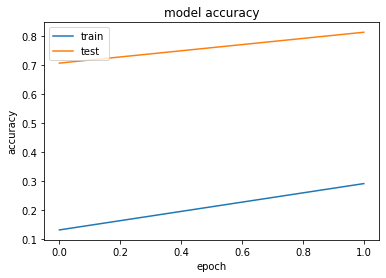

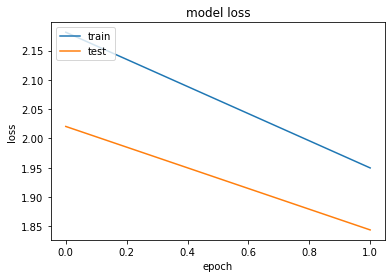

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 1.6898 - accuracy: 0.4552 - val_loss: 1.2181 - val_accuracy: 0.9200
Epoch 2/2
7/7 [==============================] - 22s 3s/step - loss: 1.3468 - accuracy: 0.6041 - val_loss: 0.8697 - val_accuracy: 0.9200
Training Performance [0.9610665440559387, 0.8740741014480591]
Testing Performance [0.8696669340133667, 0.9200000166893005]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


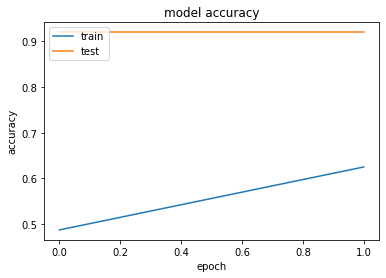

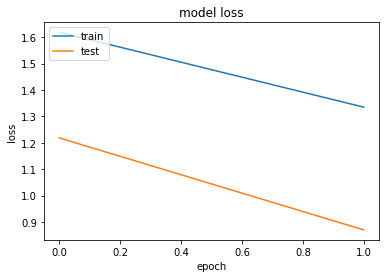

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 1.1795 - accuracy: 0.7310 - val_loss: 1.2105 - val_accuracy: 0.7200
Epoch 2/2
7/7 [==============================] - 21s 3s/step - loss: 1.0272 - accuracy: 0.7872 - val_loss: 1.1764 - val_accuracy: 0.7200
Training Performance [0.7163441181182861, 0.8962963223457336]
Testing Performance [1.1763637065887451, 0.7200000286102295]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


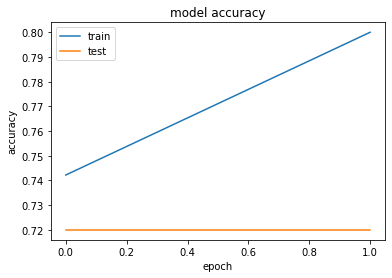

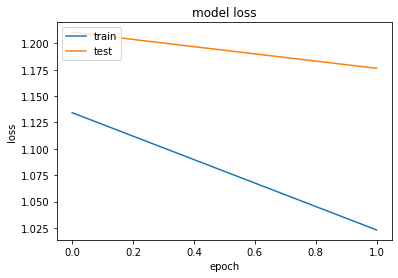

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.9701 - accuracy: 0.8311 - val_loss: 0.8332 - val_accuracy: 0.8667
Epoch 2/2
7/7 [==============================] - 22s 3s/step - loss: 0.8626 - accuracy: 0.8692 - val_loss: 0.8007 - val_accuracy: 0.8667
Training Performance [0.7652554512023926, 0.8799999952316284]
Testing Performance [0.8006852865219116, 0.8666666746139526]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


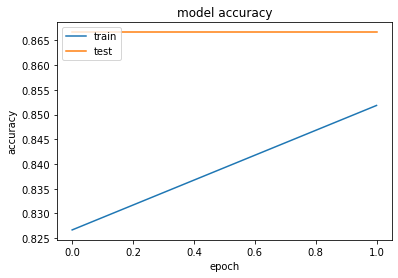

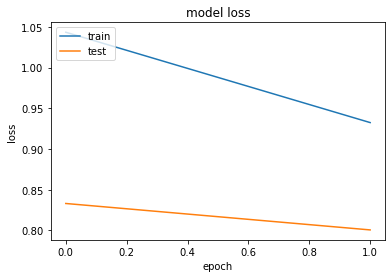

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.9220 - accuracy: 0.8563 - val_loss: 0.7421 - val_accuracy: 0.8800
Epoch 2/2
7/7 [==============================] - 21s 3s/step - loss: 0.8738 - accuracy: 0.8689 - val_loss: 0.7181 - val_accuracy: 0.8800
Training Performance [0.7233300805091858, 0.8785185217857361]
Testing Performance [0.7180953025817871, 0.8799999952316284]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


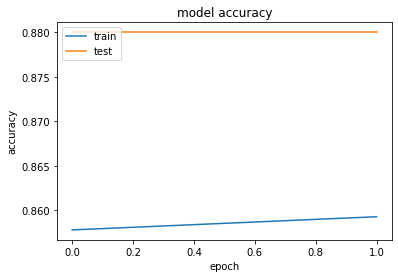

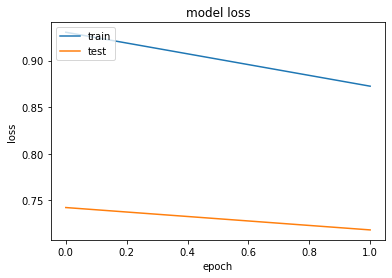

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.8334 - accuracy: 0.8690 - val_loss: 0.5719 - val_accuracy: 0.9467
Epoch 2/2
7/7 [==============================] - 21s 3s/step - loss: 0.8778 - accuracy: 0.8672 - val_loss: 0.5510 - val_accuracy: 0.9467
Training Performance [0.7103538513183594, 0.8711110949516296]
Testing Performance [0.5510340332984924, 0.9466666579246521]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


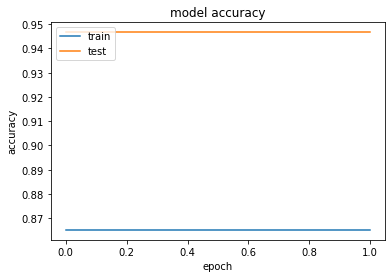

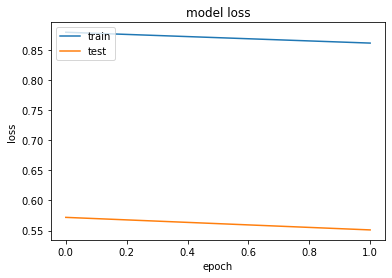

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.8642 - accuracy: 0.8571 - val_loss: 0.3575 - val_accuracy: 0.9600
Epoch 2/2
7/7 [==============================] - 22s 3s/step - loss: 0.7484 - accuracy: 0.8661 - val_loss: 0.3926 - val_accuracy: 0.9600
Training Performance [0.6230670213699341, 0.8696296215057373]
Testing Performance [0.3925754725933075, 0.9599999785423279]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


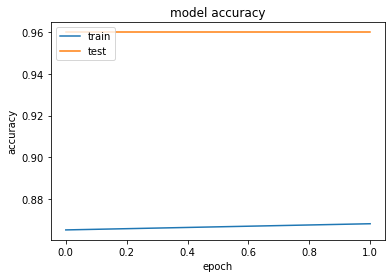

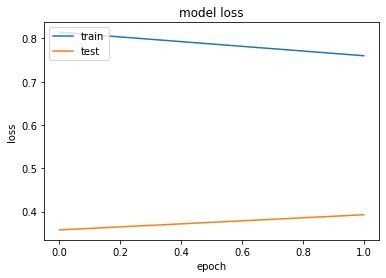

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.7887 - accuracy: 0.8792 - val_loss: 0.7889 - val_accuracy: 0.8267
Epoch 2/2
7/7 [==============================] - 22s 3s/step - loss: 0.6491 - accuracy: 0.9049 - val_loss: 0.7918 - val_accuracy: 0.8267
Training Performance [0.5711315870285034, 0.8844444155693054]
Testing Performance [0.7918114066123962, 0.8266666531562805]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


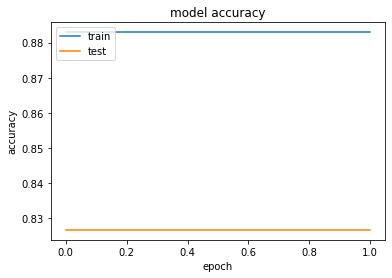

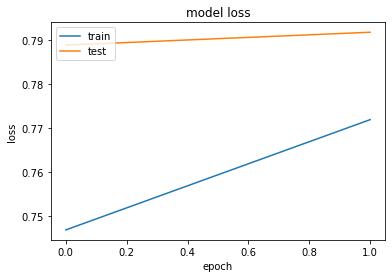

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.6769 - accuracy: 0.8898 - val_loss: 0.4507 - val_accuracy: 0.9467
Epoch 2/2
7/7 [==============================] - 21s 3s/step - loss: 0.7698 - accuracy: 0.8757 - val_loss: 0.4617 - val_accuracy: 0.9467
Training Performance [0.6466864943504333, 0.8711110949516296]
Testing Performance [0.4617369472980499, 0.9466666579246521]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


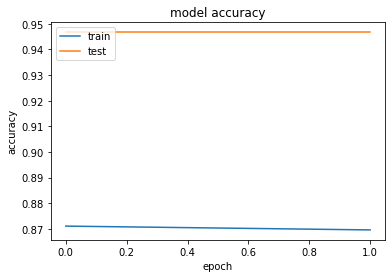

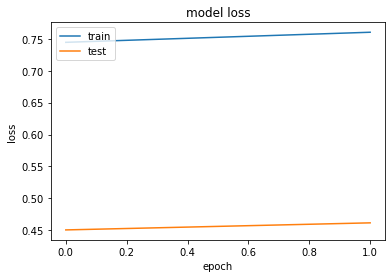

(675, 40)
(75, 40)
75 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
675 40
<class 'numpy.ndarray'>
<class 'int'>
<class 'list'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
(675,) (675,) (75,) (75,)
(675, 40) (675,) (75, 40) (75,)
Epoch 1/2
7/7 [==============================] - 27s 3s/step - loss: 0.7111 - accuracy: 0.8777 - val_loss: 0.5078 - val_accuracy: 0.9067
Epoch 2/2
7/7 [==============================] - 21s 3s/step - loss: 0.7811 - accuracy: 0.8707 - val_loss: 0.5709 - val_accuracy: 0.9067
Training Performance [0.6502494215965271, 0.8755555748939514]
Testing Performance [0.5709254145622253, 0.9066666960716248]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


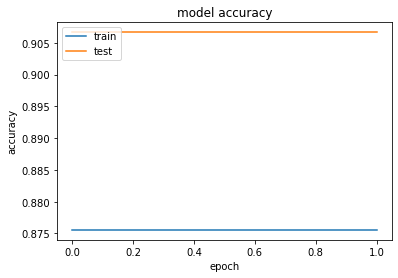

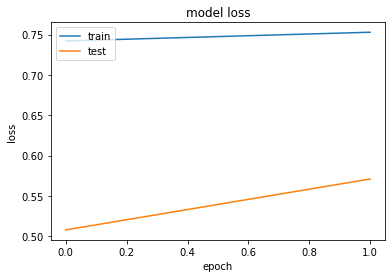

In [31]:
#Cross Validation:
trainacc=[]
testacc=[]
for i in range(0,Folds):
    TestX=xx[foldlen*(i):foldlen*(i+1)];
    TestY=yy[foldlen*(i):foldlen*(i+1)];
    testfold=np.arange(foldlen*(i),foldlen*(i+1));
    trainfold=np.arange(0,samples);
    #for j in range(0,foldlen):
    trainfold=np.delete(trainfold,testfold);
    TrainX=xx[trainfold];
    TrainY=yy[trainfold];
    print(TrainX.shape);
    print(TestX.shape);
    
    m,n=TestX.shape
    ## Converting form and reshaping
    testy=np.reshape(TestY,(m,))
    ## Changing datatypes
    testx=np.empty((m,),object)
    for i in range (0,m):
        testx[i]=list(int(v) for v in TestX[i])
        testy[i]=testy[i].astype(int)
    ## Printing data-types - relevant to transformer input

    ## Converting Train Data and Getting size of data
    m,n=TrainX.shape
    print(m,n)
    ## Converting form and reshaping
    trainy=np.reshape(TrainY,(m,))
    ## Changing datatypes
    trainx=np.empty((m,),object)
    for i in range (0,m):
        trainx[i]=list(int(v) for v in TrainX[i])
        trainy[i]=TrainY[i].astype(int)    
    ## Printing data-types - relevant to transformer input
    
    trainx = keras.preprocessing.sequence.pad_sequences(trainx,maxlen=maxlen)
    testx = keras.preprocessing.sequence.pad_sequences(testx,maxlen=maxlen)
    print(trainx.shape,trainy.shape,testx.shape,testy.shape)
    
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(trainx, trainy, batch_size=100, epochs=12,validation_data=(testx, testy))
    
    score = model.evaluate(trainx, trainy, verbose=0)
    print("Training Performance",score)
    trainacc.append(score)
    score = model.evaluate(testx, testy, verbose=0)
    print("Testing Performance",score)
    testacc.append(score)
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    del history
    keras.backend.clear_session()

[[1.8166382312774658, 0.8859259486198425], [0.9610665440559387, 0.8740741014480591], [0.7163441181182861, 0.8962963223457336], [0.7652554512023926, 0.8799999952316284], [0.7233300805091858, 0.8785185217857361], [0.7103538513183594, 0.8711110949516296], [0.6230670213699341, 0.8696296215057373], [0.5711315870285034, 0.8844444155693054], [0.6466864943504333, 0.8711110949516296], [0.6502494215965271, 0.8755555748939514]]


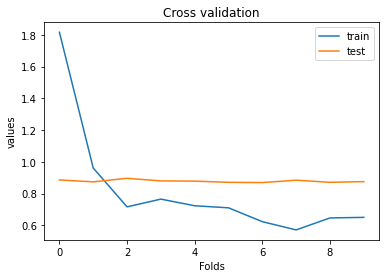

In [42]:
print(trainacc)
plt.plot(trainacc)
plt.title('Cross validation')
plt.ylabel('values')
plt.xlabel('Folds')
plt.yscale('linear')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

[[1.8437172174453735, 0.8133333325386047], [0.8696669340133667, 0.9200000166893005], [1.1763637065887451, 0.7200000286102295], [0.8006852865219116, 0.8666666746139526], [0.7180953025817871, 0.8799999952316284], [0.5510340332984924, 0.9466666579246521], [0.3925754725933075, 0.9599999785423279], [0.7918114066123962, 0.8266666531562805], [0.4617369472980499, 0.9466666579246521], [0.5709254145622253, 0.9066666960716248]]


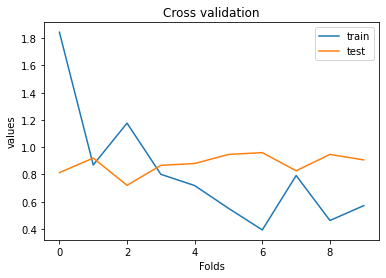

In [43]:
print(testacc)
plt.plot(testacc)
plt.title('Cross validation')
plt.ylabel('values')
plt.xlabel('Folds')
plt.yscale('linear')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
del model